In [2]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.4 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
#provides functions for interacting with the operating system. allows various os related tasks such as file and directory operations
import os


#library used for deep learning. provides data structures for multi dimensional tensions and math operation on tjose tensors. Good for training neural networks.
import torch


#package designed to do computer vision tasks. Includes utilities to load datasets, pretrained models, image transformations and common image datasets.
import torchvision


#used for working with datasets and data loaders in pytorch. random split is used to split a dataset into RANDOM train and validation datasets.
from torch.utils.data import random_split


#provides access to pre defined neural network models for comp vision tasks. Can be used for tasks like image classification, object detection and any image segmentation.
import torchvision.models as models


#provides classes and functions to build neural networks using Pytorch. Includes various layers, activation functions and other utilities required for constructing deep learning models
import torch.nn as nn


import torch.nn.functional as F

In [4]:
#directory for where the dataset for the garbage classification is stored
data_dir  = '/Users/ahsansultan/HACK PSU Spring 2024/archive (1)/Garbage classification/Garbage classification'


#os.listdir() will return the list containing the names of the entries in the directory which is given by the path data_dir
classes = os.listdir(data_dir)


#this just simply prints out that list that os.listdir() creates
print(classes)

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


In [5]:
#image folder is a dataset class provided by pytorch which will load images from the directory structure where each subdirectory represents a class and images within those subdirectories belong to the class.
from torchvision.datasets import ImageFolder


#brings in the transform module. transforms would be any operations that are applied to the data during the loading phase. Examples include resizing, normalizing or augmenting data
import torchvision.transforms as transforms


#transforms.compose simply allows you to chain multiple transformations together
#transforms.resize allow you to resize the input images to a 256 image height by 256 image width
#transforms.ToTensor allow you to convert the image data into pytorch tensors
transformations = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

#this allows you to create an instance of the ImageFolder dataset class
dataset = ImageFolder(data_dir, transform = transformations)

In [6]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /Users/ahsansultan/HACK PSU Spring 2024/archive (1)/Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

#helper function to see the image and the corresponding label attached to it.
#the img in here that is being passed is an image tensor.
#the img here will be the image data that is being displayed which is expected to be a pytorch tensor.
#this represents the label or the class of the image

def show_sample(img, label):

    #prints the label of the image. It uses the class attributes of the dataset object to get the class name corresponding to the given label
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    #this line will visualize the image using imshow. Moreover, the img.permute will change of the image tensors to the order for imshow and matplot lib
    plt.imshow(img.permute(1, 2, 0))


Label: cardboard (Class No: 0)


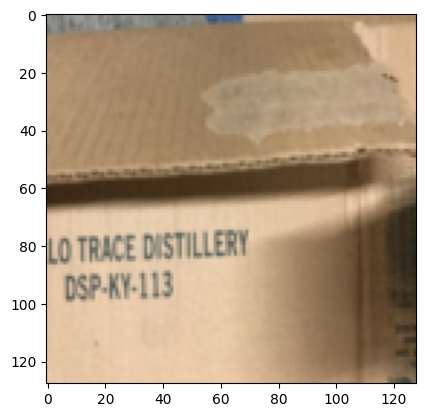

In [8]:
#this code chunk is simply to visualize a specific sample from the image dataset
#accesses the 13th image along with the corresponding label from the dataset. dataset object behaves like a python list or array
#allows you to use indexing to access any individual samples. This will retrieves the image tensor and the associated label

img, label = dataset[12]

#it just shows you the sample
show_sample(img, label)

In [9]:
#the code chunk is used the fix the seed which helps ensure that experiments are deterministic and can be reproduced exactly, essential for debugging.
#represents the seed value which will be used to initialize the random no generator
random_seed = 42
#initializes the random no generator with the specified seed to ensure that everytime you run you will get the same sequence of numbers which helps to make your programs reproducible.
torch.manual_seed(random_seed)

In [10]:
#splitting the dataset into training, validation and testing data set and predefining using an array what you want each of them to have
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [11]:
print(train_ds)

In [12]:
#involves setting up a pytorch dataloader object with a already specified batch size.
#dataloader is used to load data froma data set and provide batches of data to the model while training or evaluating it.


from torch.utils.data.dataloader import DataLoader


#when you do deep learning, training models on the full dataset is very memory intensive. Hence you divide the dataset into smaller batches with the model being trained on each batch iteratively. Batch size is basically the number of samples(datapoints) which would be processed together in each iteration of training
batch_size = 16

In [15]:
#creates a dataloader for the training dataset.
#shuffles the data so that the model sees different samples in each epoch
#setting the value for num_workers higher than 4 allows for parallel data loading, speeding up the data loading process.
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0)

#pim memory essentially copies data tensors to CUDA pinned memory, accelerating data transfer between CPU and GPU during training
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 0)

In [16]:
#helper function to be able to visualize batches and make them in the form of a grid.
#imports make grid which is a function of pytorch which can create a grid of images from a batch of image tensors
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

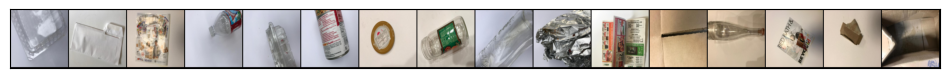

In [17]:
show_batch(train_dl)

In [18]:
#function to calculate the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

In [20]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cpu')

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
model = to_device(ResNet(), device)

In [26]:
evaluate(model, val_dl)

{'val_loss': 1.8119277954101562, 'val_acc': 0.1458333283662796}

In [45]:
#88.61 when batch size is 64
#89 when batch size is 32
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch 1: train_loss: 1.0637, val_loss: 1.1272, val_acc: 0.9219
Epoch 2: train_loss: 1.0592, val_loss: 1.1382, val_acc: 0.9115
Epoch 3: train_loss: 1.0578, val_loss: 1.1521, val_acc: 0.8802
Epoch 4: train_loss: 1.0595, val_loss: 1.1298, val_acc: 0.9010
Epoch 5: train_loss: 1.0541, val_loss: 1.1205, val_acc: 0.8906
Epoch 6: train_loss: 1.0591, val_loss: 1.1507, val_acc: 0.8802
Epoch 7: train_loss: 1.0570, val_loss: 1.1416, val_acc: 0.8906
Epoch 8: train_loss: 1.0537, val_loss: 1.1481, val_acc: 0.8958


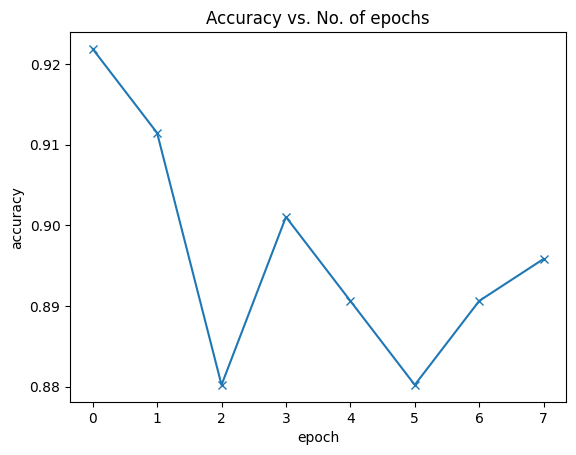

In [46]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

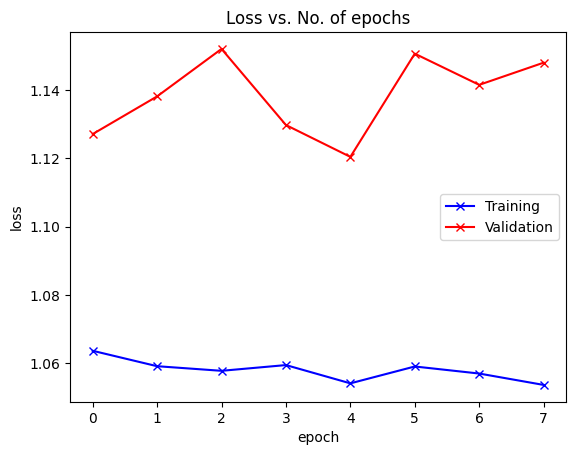

In [47]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [48]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


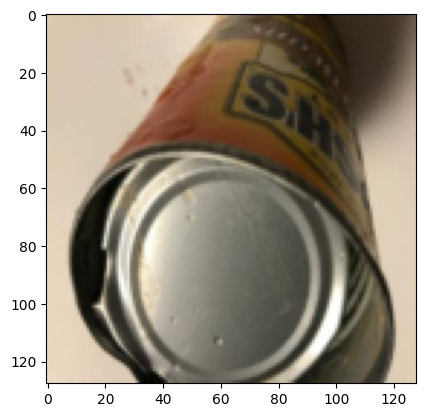

In [49]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


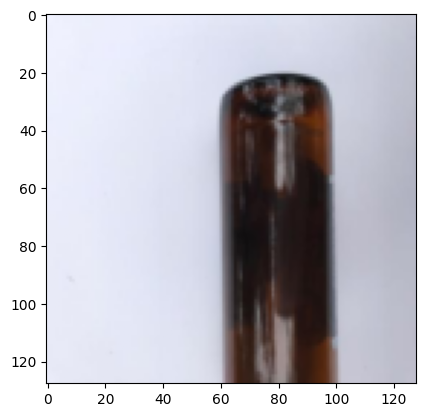

In [50]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


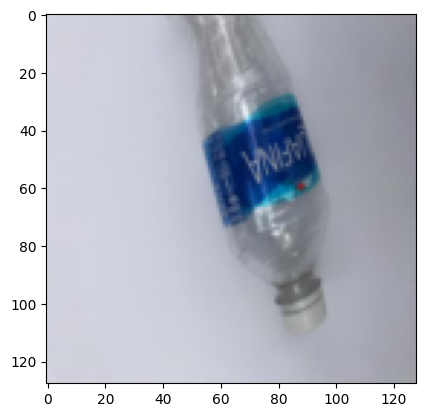

In [52]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))


In [53]:
loaded_model = model

In [54]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('/Users/ahsansultan/HACK PSU Spring 2024/' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles metal.


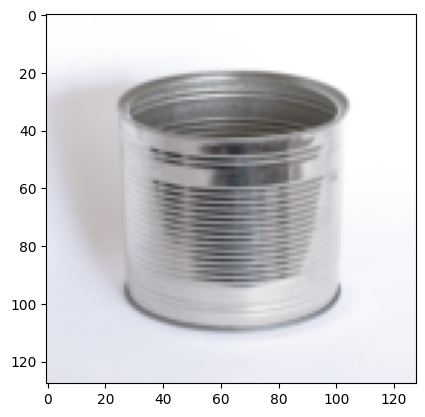

In [63]:
predict_external_image('Empty_tin_can2009-01-19.jpg')

The image resembles cardboard.


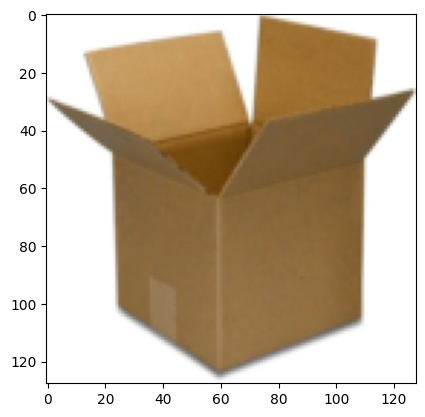

In [64]:
predict_external_image('41ecP8NkWoL._AC_UF894,1000_QL80_.jpg')

The image resembles paper.


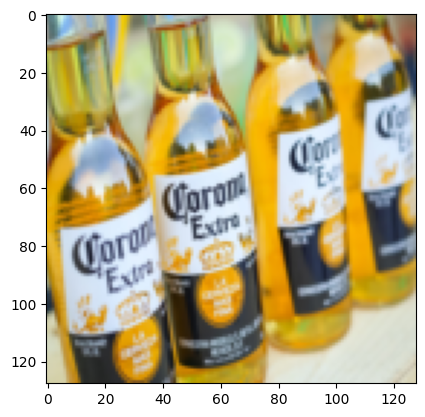

In [65]:
predict_external_image('shutterstock_672353038.jpg')

The image resembles cardboard.


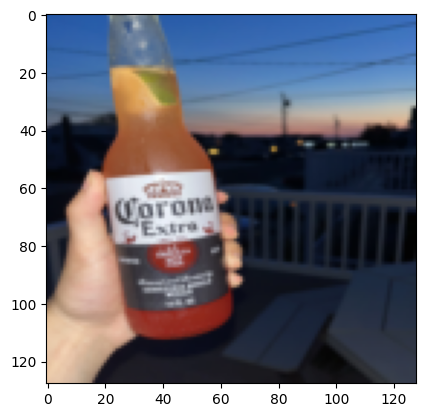

In [66]:
predict_external_image('corona_sunrise.jpg')

The image resembles paper.


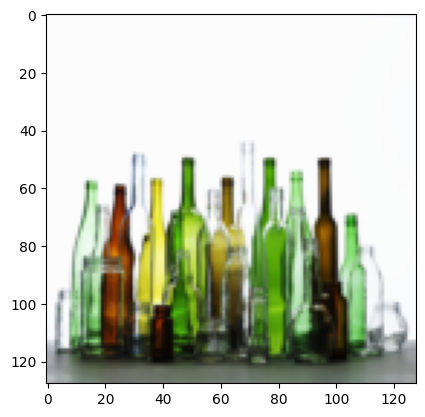

In [67]:
predict_external_image('glass_bottles_materials_ff.jpg')

The image resembles glass.


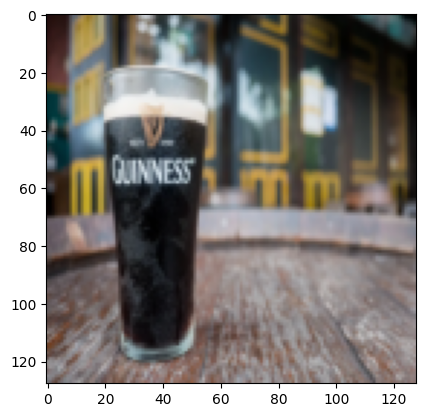

In [68]:
predict_external_image('567.jpg')

In [56]:
import os

file_path = '/Users/ahsansultan/HACK PSU Spring 2024/metal.jpg'
if os.path.exists(file_path):
    print(f"The file {file_path} exists.")
else:
    print(f"The file {file_path} does not exist or the path is incorrect.")

The file /Users/ahsansultan/HACK PSU Spring 2024/metal.jpg exists.


In [57]:
from PIL import Image

try:
    with Image.open(file_path) as img:
        print(f"Image format: {img.format}")
except IOError:
    print("The file is not a valid image or is corrupted.")

The file is not a valid image or is corrupted.


The image resembles metal.


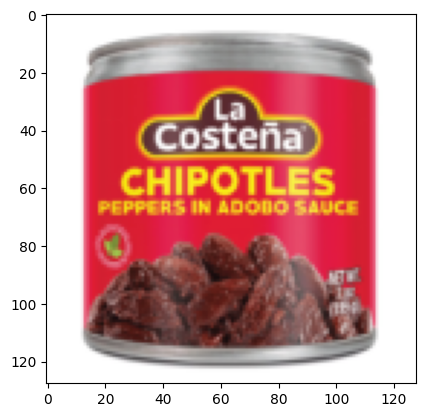

In [69]:
predict_external_image('chipotle.jpg')

The image resembles plastic.


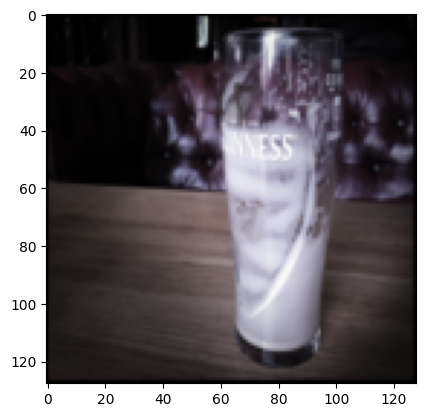

In [70]:
predict_external_image('emptygui.jpg')

In [148]:
torch.save(model.state_dict(), 'trained_model1.pth')